In [1]:
# import datasets

import pandas as pd

cols = ['X', 'Y']
df_square = pd.read_csv('./Datasets/square.txt', sep=" ", names=cols, header=None)

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

Text(0, 0.5, 'SSE')

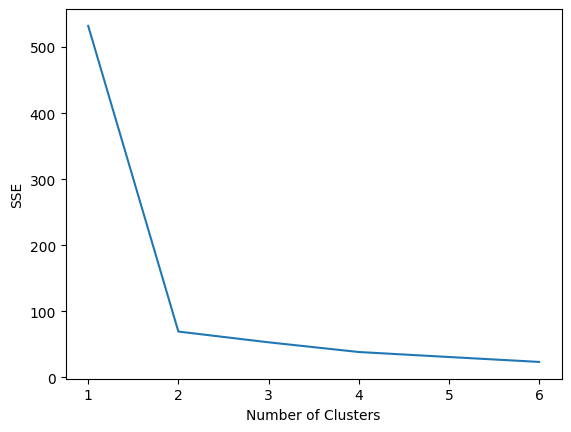

In [2]:
# estimate the number of clusters using a SSE vs. number of clusters graph

from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(df_square)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

<AxesSubplot: xlabel='X', ylabel='Y'>

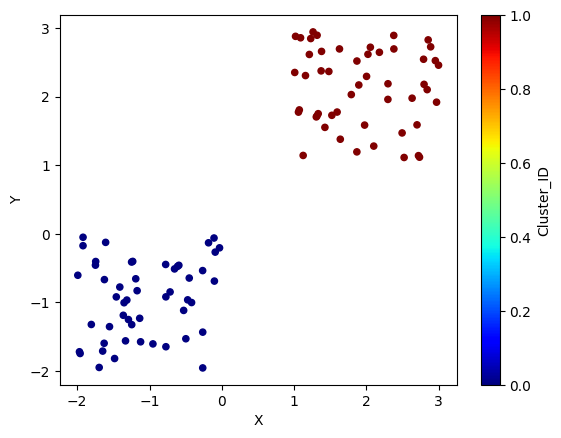

In [130]:
# implement spectral clustering

from sklearn import cluster

spectral = cluster.SpectralClustering(n_clusters=2,random_state=1,affinity='rbf',gamma=10)
spectral.fit(df_square)
df_square['Cluster_ID'] = spectral.labels_

# plot the clusters

df_square.plot.scatter(x='X',y='Y',c='Cluster_ID',colormap='jet')

In [131]:
# split the clusters into vectors

cluster_0 = df_square[df_square['Cluster_ID'] == 0]
del cluster_0['Cluster_ID']
cluster_0 = cluster_0.to_numpy().tolist()

cluster_1 = df_square[df_square['Cluster_ID'] == 1]
del cluster_1['Cluster_ID']
cluster_1 = cluster_1.to_numpy().tolist()

# implement cosine similarity measure for the 2 clusters

from scipy import spatial
import numpy as np

cos_sim = []
for i in range(len(cluster_0)):
    sim = 1 - spatial.distance.cosine(cluster_0[i], cluster_1[i])
    cos_sim.append(sim)

print('Cosine Similarity Average: ', np.average(cos_sim))


Cosine Similarity Average:  -0.9118839688838639


In [132]:
# implement gaussian kernel similarity

def gaussian_sim (x, y, sigma): 
    return np.exp (- (np.linalg.norm (x - y) ** 2) / (2 * sigma ** 2))

# set bandwidth parameter
sigma = 1

# convert clusters from list to array to fit the function
cluster_0 = np.array(cluster_0)
cluster_1 = np.array(cluster_1)

# calculate similarity matrix
similarity_matrix = np.zeros ((len (cluster_0), len (cluster_1)))

for i in range (len (cluster_0)): 
    for j in range (len (cluster_0)): 
        similarity_matrix [i, j] = gaussian_sim(cluster_0[i], cluster_1[j], sigma)

print('Gaussian Similarity Average: ', np.average(similarity_matrix))

Gaussian Similarity Average:  0.0028444072795836355


Unnormalized Laplacian Matrix L: 
   (4, 4)	1.0
  (4, 23)	-1.0
  (13, 13)	22.5
  (13, 23)	-22.5
  (23, 4)	-1.0
  (23, 13)	-22.5
  (23, 23)	25.0
  (23, 45)	-1.5
  (45, 23)	-1.5
  (45, 45)	1.5

Eigenvalues: 
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.32552888e-17 2.22044605e-16
 9.21795717e-16 1.15324904e-15 1.80696379e-15 2.64292029e-15
 4.16922032e-15 1.15591884e+00 2.52122188e+00 4.63228593e+01]
Fiedler vector mininum:  1.0000000000000002
Fiedler vector m

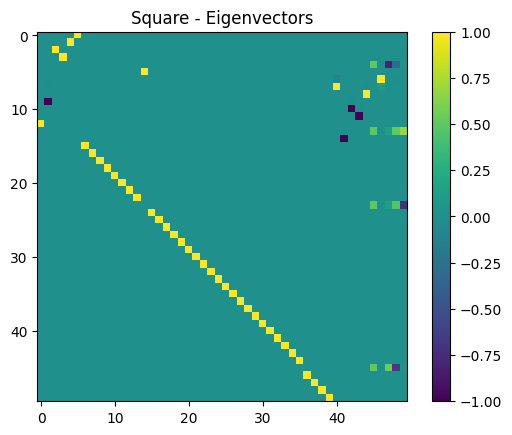

In [133]:
# unnormalized Laplacian matrix

import scipy.sparse as sp
import scipy.spatial as sps
import scipy.linalg as spl
import matplotlib.pyplot as plt

# create weighted adjacency matrix W using k-nearest neighbors
k = 1
dist_matrix = sps.distance.cdist(cluster_0, cluster_1, metric='euclidean')
ind = dist_matrix.argsort(axis=1)[:, :k + 1].T
dist = dist_matrix[ind[0], ind[1]]
W = sp.coo_matrix((np.ones(dist.shape), (ind[0], ind[1])), shape=(cluster_0.shape[0], cluster_1.shape[0]))
W = (W + W.T) / 2 # make W symmetric

# create degree matrix D
D = sp.diags(W.sum(axis=0).A1)

# create unnormalized Laplacian matrix L
L = D - W

# calculate eigenvalues and eigenvectors of L
eigen_vals, eigen_vecs = spl.eigh(L.toarray())

# print results
print('Unnormalized Laplacian Matrix L: \n', L)
print('\nEigenvalues: \n', np.sort(eigen_vals[eigen_vals >= 0]))
print('Fiedler vector mininum: ', np.ndarray.max(eigen_vecs))
print('Fiedler vector maximum: ', np.ndarray.min(eigen_vecs))
plt.imshow(eigen_vecs, interpolation='none', cmap = 'viridis')
plt.title("Square - Eigenvectors")
plt.colorbar()
plt.show()

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\csgraph\_laplacian.py:546: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(isolated_node_mask, 1, np.sqrt(w))


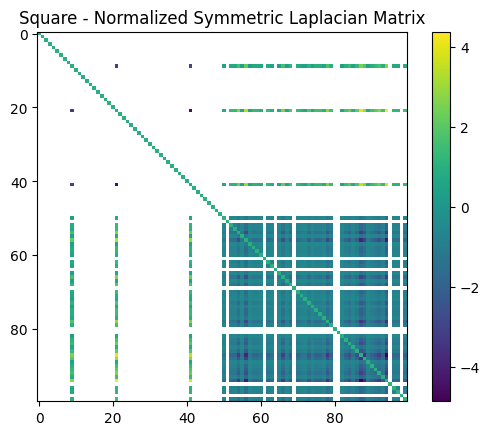

In [134]:
# normalized symmetric laplacian matrix

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import laplacian

# combine clusters into one array
points = np.concatenate((cluster_0, cluster_1), axis=0)

# compute the cosine similarity matrix
C = cosine_similarity (points)

# compute normalized symmetric Laplacian matrix
L_norm_sym = laplacian(C, normed=True)

# show results
plt.imshow(L_norm_sym, interpolation='none', cmap = 'viridis')
plt.colorbar()
plt.title("Square - Normalized Symmetric Laplacian Matrix")
plt.show()